In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from scipy.stats import ttest_rel,wilcoxon,ranksums,ttest_ind
from statsmodels.stats.multitest import multipletests
from sklearn.cluster import AgglomerativeClustering
import sys
sys.path.append("../code")
from analysis_utils import *

# Original KMAC/DeepAccess Library

In [2]:
df = pd.read_table('../data/KMAC-DeepAccess-library.csv')
deepaccess_predictions = pd.read_csv('../data/SLOTv3_ensemble_predictions.txt',sep=' ',header=None)
df['DE.prediction'] = deepaccess_predictions[0]
df['ESC.prediction'] = deepaccess_predictions[1]
df['kmer'] = [get_kmer(d) for d  in df['description']]
df['control'] = [get_type(c) for c in df['category']]
df['background'] = [get_bg(d) for d in df['description']]
df['kmer'].fillna('None', inplace=True)
df['background'].fillna('None', inplace=True)
df['gc.content'] = [(seq.count('G')+seq.count('C'))/len(seq) for seq in df['seq']]
df['catdesc'] =[cat2desc[c.strip('S')] for c in df['category']]

In [3]:
for cat in set(df['catdesc']):
    print(cat,'N=',list(df[df['control'] != 'scrambled']['catdesc']).count(cat))

universally opening phrases with GC content between 30 - 50 % N= 50
universally opening phrases with GC content between 60 - 70 % N= 50
ED-Salient-Top N= 312
ES-Native N= 129
ED-Salient-TF N= 360
SLOT-CNN N= 600
ES-Salient-Top N= 312
background N= 24
ED-Native N= 84
universally closing phrases with GC content between 30 - 50 % N= 50
phrases opening ED cells using one or more occurrences of one k-mer per phrase N= 120
universally closing phrases with GC content between 60 - 70 % N= 50
opening ES cells using combinations of k-mers per phrase N= 312
phrases opening ED cells using combinations of k-mers per phrase N= 288
opening ES cells using one or more occurrences of one k-mer per phrase N= 120
ES-Salient-TF N= 240


In [4]:
opening_cat_low='universally opening phrases with GC content between 30 - 50 %'
closing_cat_low='universally closing phrases with GC content between 30 - 50 %'
opening_cat_high='universally opening phrases with GC content between 60 - 70 %'
closing_cat_high='universally closing phrases with GC content between 60 - 70 %'

In [5]:
norm = df.copy()
for i in range(1,5):
    for j in range(1,3):
        norm['dpnii.es'+str(i)+'.'+str(j)] = norm['dpnii.es'+str(i)+'.'+str(j)]/np.sum(norm['dpnii.es'+str(i)+'.'+str(j)]/1000000)
        norm['dpni.es'+str(i)+'.'+str(j)] = norm['dpni.es'+str(i)+'.'+str(j)]/np.sum(norm['dpni.es'+str(i)+'.'+str(j)]/1000000)
        norm['es'+str(i)+'.'+str(j)] = norm['dpnii.es'+str(i)+'.'+str(j)]/(norm['dpnii.es'+str(i)+'.'+str(j)] + norm['dpni.es'+str(i)+'.'+str(j)])
for i in range(1,3):
    for j in range(1,3):
        norm['dpnii.ed'+str(i)+'.'+str(j)] = norm['dpnii.ed'+str(i)+'.'+str(j)]/np.sum(norm['dpnii.ed'+str(i)+'.'+str(j)]/1000000)
        norm['dpni.ed'+str(i)+'.'+str(j)] = norm['dpni.ed'+str(i)+'.'+str(j)]/np.sum(norm['dpni.ed'+str(i)+'.'+str(j)]/1000000)
        norm['ed'+str(i)+'.'+str(j)] = norm['dpnii.ed'+str(i)+'.'+str(j)]/(norm['dpnii.ed'+str(i)+'.'+str(j)] + norm['dpni.ed'+str(i)+'.'+str(j)])

/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


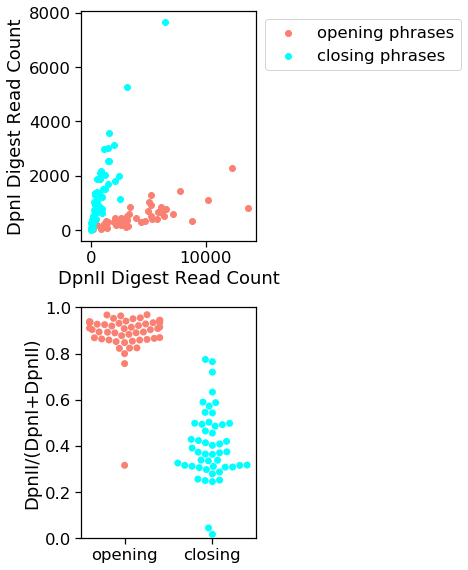

In [6]:
sns.set_context('notebook',font_scale=1.5)
opening=df[df['catdesc'] == opening_cat_low]
closing = df[df['catdesc'] == closing_cat_low]
plt.figure(figsize=(4,8))
plt.subplot(2,1,1)
plt.scatter(opening['dpnii.ed2.1'],opening['dpni.ed2.1'],color='salmon',label='opening phrases')
plt.scatter(closing['dpnii.ed2.1'],closing['dpni.ed2.1'],color='aqua',label='closing phrases')
plt.ylabel('DpnI Digest Read Count')
plt.xlabel('DpnII Digest Read Count')
plt.tight_layout()
plt.legend(bbox_to_anchor=(1,1))
ax = plt.subplot(2,1,2)
sns.swarmplot(x='catdesc',y='ed2.1',data=norm,
              order=[opening_cat_low,
                     closing_cat_low],
              palette={opening_cat_low:'salmon',
                       closing_cat_low:'aqua'},
              s=7)
plt.xlabel('')
plt.ylabel('DpnII/(DpnI+DpnII)')
ax.set_xticklabels(['opening','closing'])
plt.axis([-0.5,1.5,0,1.0])
plt.tight_layout()
plt.savefig('plots/read-dpn-ratio-from-ed3-1.svg')

In [7]:
num_greater = []
for rep in ['ed1.1','ed1.2','ed2.1','ed2.2','es1.1','es1.2','es2.1','es2.2','es3.1','es3.2','es4.1','es4.2']:
    avg = np.mean(norm[(norm['catdesc']==closing_cat_low)|(norm['catdesc']==closing_cat_high)][rep])
    greater = sum( ((norm['catdesc']==opening_cat_low) | (norm['catdesc']==opening_cat_high)) & (norm[rep] > avg))
    num_greater.append(greater)
np.mean(greater)

87.0

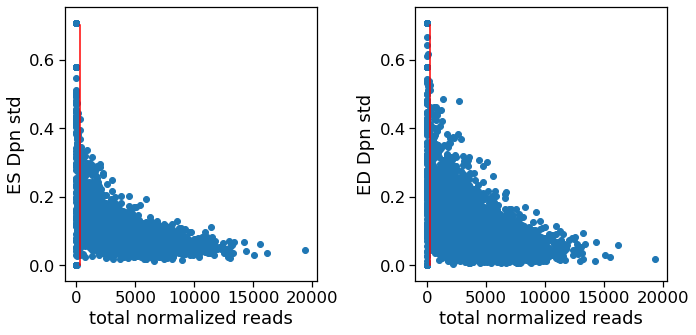

In [10]:
norm['ES Dpn std'] = norm[[c for c in norm.columns if c[:2] == 'es']].std(axis=1)
norm['ED Dpn std'] = norm[[c for c in norm.columns if c[:2] == 'ed']].std(axis=1)

plt.figure(figsize=(10,5))
norm['total normalized reads'] = norm[[c for c in norm.columns if 'dpni' in c or 'dpnii' in c]].sum(axis=1)
plt.subplot(1,2,1)
plt.scatter(x='total normalized reads',y='ES Dpn std',data=norm)
plt.plot([300,300],[0.0,0.7],color='r')
plt.xlabel('total normalized reads')
plt.ylabel('ES Dpn std')
plt.tight_layout()
plt.subplot(1,2,2)
norm['total_reads'] = norm[[c for c in norm.columns if 'dpni' in c or 'dpnii' in c]].sum(axis=1)
plt.scatter(x='total normalized reads',y='ED Dpn std',data=norm)
plt.plot([300,300],[0.0,0.7],color='r')
plt.xlabel('total normalized reads')
plt.ylabel('ED Dpn std')
plt.tight_layout()
plt.savefig('plots/threshold_6k_library.svg')

In [11]:
norm = norm[norm['total normalized reads'] > 300]
# TODO edit so phrases without controls are not N/As
norm.dropna(inplace=True)

In [12]:
len(norm)

5507

In [13]:
norm['ED Dpn ratio'] = (norm['ed1.1']+norm['ed1.2']+norm['ed2.1']+norm['ed2.2'])/4.0
norm['ES Dpn ratio'] = (norm['es1.1']+norm['es1.2']+norm['es2.1']+norm['es2.2']+norm['es3.1']+norm['es3.2']+norm['es4.1']+norm['es4.2'])/8.0

# Native phrases are differentially accessible 

/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


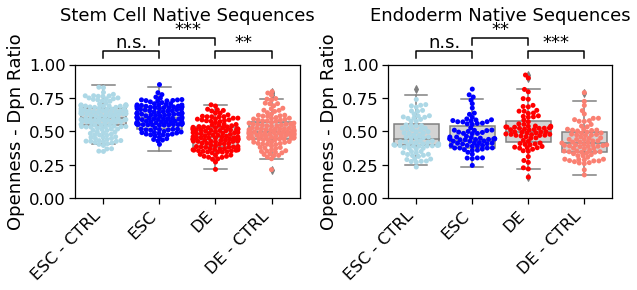

In [14]:
plt.figure(figsize=(9,3))
keep = norm[norm['catdesc']=='ED-Native']
keep['native_name'] = [d.split('/')[0] for d in keep.description]

keeppivot = pd.pivot_table(data=keep,
                           index=['native_name'],
                           columns=['control'],values=['ES Dpn ratio','ED Dpn ratio']).dropna()
plt.subplot(1,2,2)
plot_dotplot(keep,['seq','catdesc','control','kmer','background'],
             keeppivot,plot_lines=False,plot_boxplot=True,title='Endoderm Native Sequences')
keep = norm[norm['catdesc']=='ES-Native']
keep['native_name'] = [d.split('/')[0] for d in keep.description]

keeppivot = pd.pivot_table(data=keep,
                           index=['native_name'],
                           columns=['control'],values=['ES Dpn ratio','ED Dpn ratio']).dropna()
plt.subplot(1,2,1)
plot_dotplot(keep,['seq','catdesc','control','kmer','background'],
             keeppivot,plot_lines=False,plot_boxplot=True,title='Stem Cell Native Sequences')
plt.savefig('plots/MIAA-native.svg',bbox_inches='tight')

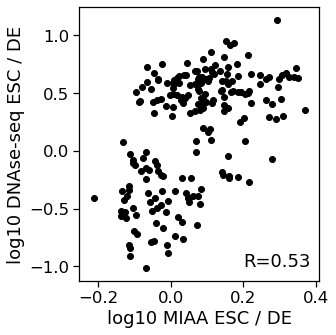

In [15]:
endo = pd.read_table('../data/native_phrases_ED_counts.bed')
stem = pd.read_table('../data/native_phrases_ES_counts.bed')
sns.set_context('notebook',font_scale=1.5)
endo.columns = ['chrm','start','stop','name','ed1','ed2','ed3']
stem.columns = ['chrm','start','stop','name','es1','es2','es3']
count_merge = endo.merge(stem)
count_merge['dnase.ed'] = count_merge['ed1'] + count_merge['ed2'] + count_merge['ed3']
count_merge['dnase.es'] = count_merge['es1'] + count_merge['es2'] + count_merge['es3']
native = norm[((norm['catdesc']=='ES-Native') | (norm['catdesc']=='ED-Native')) & (norm['control'] != 'scrambled')]
native = native[['seq','catdesc','description','ED Dpn ratio','ES Dpn ratio']]
native['name'] = [d.split('/')[0] for d in native.description]
native_counts = native.merge(count_merge,on='name')
plt.figure(figsize=(5,5))
y=np.log10(native_counts['dnase.es']/native_counts['dnase.ed'])
x=np.log10(native_counts['ES Dpn ratio']/native_counts['ED Dpn ratio'])
plt.scatter(y=y,
            x=x,color='k')
plt.text(0.2,-1.0,'R='+str(round(pearsonr(x,y)[0],2)))

plt.xlabel('log10 MIAA ESC / DE')
plt.ylabel('log10 DNAse-seq ESC / DE')
plt.tight_layout()
plt.savefig('plots/MIAA_vs_DNAse_native_change_in_accessibility.svg')

# Comparing DeepAccess predictions to MIAA

57 / 76
(0.6171320379293925, 2.9041908364619687e-09)
SpearmanrResult(correlation=0.6208612440191388, pvalue=2.1892944092504242e-09)


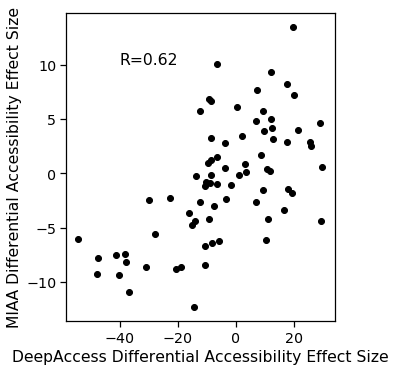

In [26]:
#TODO load DeepAccess predictions in original data frame
nmatch = 0
ntotal = 0
data_effect_size = {'kmer':[],'cnn_differential':[],'miaa_differential':[]}
sns.set_context('notebook',font_scale=1.3)
for kmer in set(norm['kmer']):
    if kmer == 'None' or kmer == 'native':
        continue
    if True:#if '-' not in kmer:
        normkmer = norm[norm['kmer'] == kmer]

        edk = pd.melt(normkmer,id_vars=['seq','catdesc','control','kmer','background'],
                  value_vars=['DE.prediction','ESC.prediction','ED Dpn ratio','ES Dpn ratio'])
        kmercompare = pd.pivot_table(data=normkmer,
                                     index=['background','kmer'],
                                     columns=['control'],
                                     values=['ED Dpn ratio','ES Dpn ratio','DE.prediction','ESC.prediction'])
        kmercompare = kmercompare.dropna()
        if len(kmercompare) > 0:
            cnn_edes = ttest_rel(kmercompare['ESC.prediction'].motif,kmercompare['DE.prediction'].motif)
            miaa_edes = ttest_rel(kmercompare['ES Dpn ratio'].motif,kmercompare['ED Dpn ratio'].motif)
            if cnn_edes[0] > 0 and miaa_edes[0] > 0:
                nmatch+=1
            elif cnn_edes[0] < 0 and miaa_edes[0] < 0:
                nmatch += 1
                        #sns.boxplot(y='variable',x='value',hue='control',data=edk)
            ntotal+=1

            data_effect_size['kmer'].append(kmer)
            data_effect_size['cnn_differential'].append(cnn_edes[0])
            data_effect_size['miaa_differential'].append(miaa_edes[0])
print(nmatch,'/',ntotal)
plt.figure(figsize=(5.5,5.5))
plt.scatter('cnn_differential','miaa_differential',data=data_effect_size,color='k')
plt.xlabel('DeepAccess Differential Accessibility Effect Size')
plt.ylabel('MIAA Differential Accessibility Effect Size')
plt.tight_layout()
plt.text(-40,10,'R='+str(round(pearsonr(data_effect_size['cnn_differential'],
                                                data_effect_size['miaa_differential'])[0],2)))
plt.savefig('plots/CNN_MIAA_motif_effect_size.svg')
print(pearsonr(data_effect_size['cnn_differential'],data_effect_size['miaa_differential']))
print(spearmanr(data_effect_size['cnn_differential'],data_effect_size['miaa_differential']))

# GC content influences accessibility

RanksumsResult(statistic=-2.743428511917159, pvalue=0.006080128534711383)
RanksumsResult(statistic=8.454238883663082, pvalue=2.809136798361035e-17)
RanksumsResult(statistic=3.8771923357196587, pvalue=0.00010566882294854292)
RanksumsResult(statistic=8.370256378196231, pvalue=5.749300833158523e-17)


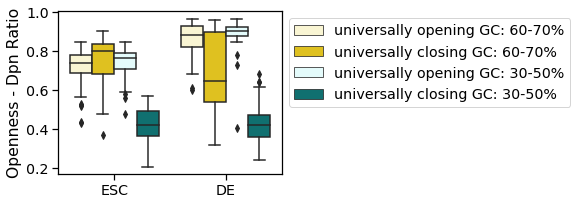

In [27]:
keep=norm[(norm['control']!='scrambled') & norm['catdesc'].isin([opening_cat_low,opening_cat_high,
                                                                closing_cat_low,closing_cat_high])]
keepmelt = pd.melt(keep,id_vars=['seq','catdesc','control','kmer','background','gc.content'],
                   value_vars=['ES Dpn ratio','ED Dpn ratio'])
plt.figure(figsize=(4,3))
sns.set_context('notebook',font_scale=1.3)
mypal={'stem cell':'blue','endoderm cell':'red'}
def rename(var):
    if var == 'ES Dpn ratio':
        return 'ESC'
    else:
        return 'DE'
def recat(var):
    name=''
    if 'opening' in var:
        name+='universally opening'
    else:
        name +='universally closing'
    if '60' in var:
        name += ' GC: 60-70%'
    else:
        name += ' GC: 30-50%'
    return name
cpal={'universally opening GC: 60-70%':'lemonchiffon',
     'universally closing GC: 60-70%':'gold',
     'universally opening GC: 30-50%':'lightcyan',
     'universally closing GC: 30-50%':'teal'
     }
keepmelt['catname'] = [recat(cat) for cat in keepmelt['catdesc']]
keepmelt['celltype'] = [rename(var) for var in keepmelt['variable']]
sns.boxplot(x='celltype',y='value',hue='catname',
               hue_order=cpal.keys(),
            data=keepmelt,palette=cpal)
plt.ylabel('Openness - Dpn Ratio')
plt.xlabel('')
print(ranksums(keep[keep['catdesc']==opening_cat_high]['ES Dpn ratio'],
               keep[keep['catdesc']==closing_cat_high]['ES Dpn ratio']))
print(ranksums(keep[keep['catdesc']==opening_cat_low]['ES Dpn ratio'],
               keep[keep['catdesc']==closing_cat_low]['ES Dpn ratio']))
print(ranksums(keep[keep['catdesc']==opening_cat_high]['ED Dpn ratio'],
               keep[keep['catdesc']==closing_cat_high]['ED Dpn ratio']))
print(ranksums(keep[keep['catdesc']==opening_cat_low]['ED Dpn ratio'],
               keep[keep['catdesc']==closing_cat_low]['ED Dpn ratio']))
plt.legend(bbox_to_anchor=(1.0,1.0))
#plt.show()
plt.savefig('plots/control_phrases_bin_results.svg',bbox_inches='tight')

Ttest_relResult(statistic=16.318052994163352, pvalue=1.710292799399432e-44)
WilcoxonResult(statistic=5790.0, pvalue=8.135973880781702e-37)
337
Ttest_relResult(statistic=15.120704455509088, pvalue=1.4907697468975374e-43)
WilcoxonResult(statistic=28916.0, pvalue=2.2170574783061564e-38)
560
Ttest_relResult(statistic=13.539611657001416, pvalue=6.781455587099819e-38)
WilcoxonResult(statistic=89462.0, pvalue=4.955214320662414e-34)
834
Ttest_relResult(statistic=5.373389264244185, pvalue=1.0597346383151295e-07)
WilcoxonResult(statistic=94491.0, pvalue=5.3850373858426535e-06)
687
Ttest_relResult(statistic=-0.13311886821749536, pvalue=0.8941715467628836)
WilcoxonResult(statistic=34134.0, pvalue=0.7891454716725672)
372


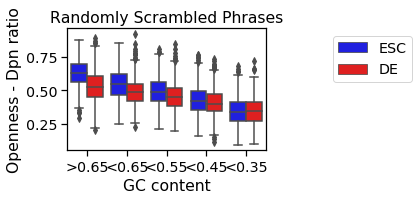

In [28]:
def gcbinned(gc_content):
    if gc_content < 0.35:
        return '<0.35'
    if gc_content < 0.45:
        return '<0.45'
    if gc_content < 0.55:
        return '<0.55'
    if gc_content < 0.65:
        return '<0.65'
    else:
        return '>0.65'
sns.set_context('notebook',font_scale=1.3)
norm['gc.bin'] = [gcbinned(d) for d in norm['gc.content']]
keep=norm[norm['control']=='scrambled']#norm[norm['category'].isin(['CAT1','CAT2','CAT3','CAT4','CAT16'])]
keepmelt = pd.melt(keep,id_vars=['seq','catdesc','control','kmer','background','gc.bin'],
                   value_vars=['ES Dpn ratio','ED Dpn ratio'])
def rename(var):
    if var == 'ES Dpn ratio':
        return 'ESC'
    else:
        return 'DE'
keepmelt['celltype'] = [rename(var) for var in keepmelt['variable']]
mypal={'ESC':'blue','DE':'red'}
#plt.figure(figsize=(7,6))
plt.figure(figsize=(5,3))

sns.boxplot(x='gc.bin',y='value',hue='celltype',order=['>0.65','<0.65','<0.55','<0.45','<0.35'],
            data=keepmelt,palette=mypal)
for order in ['>0.65','<0.65','<0.55','<0.45','<0.35']:
    tmp = keep[keep['gc.bin'] ==order]
    print(ttest_rel(tmp['ES Dpn ratio'],tmp['ED Dpn ratio']))
    print(wilcoxon(tmp['ES Dpn ratio'],tmp['ED Dpn ratio']))
    print(len(tmp))
plt.legend(bbox_to_anchor=(1.3,1.0))
plt.title('Randomly Scrambled Phrases')
plt.ylabel('Openness - Dpn ratio')
plt.xlabel('GC content')
plt.tight_layout()
#plt.show()
plt.savefig('plots/MIAA-accessibility-gccontent.svg',bbox_inches='tight')

# Identifying cell type-specific k-mers

In [ ]:
differential_tests = {}
norm_cats = norm[norm['catdesc'].isin(['ES-Salient-TF','ES-Salient-Top',
                                      'ED-Salient-TF','ED-Salient-Top',
                                      'SLOT-CNN'])]
kmers = list(set(norm_cats['kmer']))
for kmer in kmers:
    keep_kmer = norm_cats[norm_cats['kmer']==kmer]
    norm_cat_pv = pd.pivot_table(keep_kmer,index=['background'],
                                 columns=['control'],values=['ED Dpn ratio','ES Dpn ratio'])
    norm_cat_pv = norm_cat_pv.dropna()
    test_1 = wilcoxon(norm_cat_pv['ES Dpn ratio'].motif,norm_cat_pv['ED Dpn ratio'].motif)
    test_2 = ttest_rel(norm_cat_pv['ES Dpn ratio'].motif,norm_cat_pv['ED Dpn ratio'].motif)
    differential_tests[kmer]=(test_1,test_2)
    
pvals_wilcox = np.array([differential_tests[k][0][1] for k in kmers])
pvals_ttest = np.array([differential_tests[k][1][1] for k in kmers])
wilcox_reject,_,_,_ = multipletests(pvals_wilcox,method='fdr_bh')
ttest_reject,_,_,_ = multipletests(pvals_ttest,method='fdr_bh')
kmers_keep_differential = [kmers[i] for i in range(len(kmers)) if wilcox_reject[i] and ttest_reject[i]]

In [ ]:
scrambled_tests = {}

for kmer in kmers_keep_differential:
    keep_kmer = norm_cats[norm_cats['kmer']==kmer]
    norm_cat_pv = pd.pivot_table(keep_kmer,index=['background'],
                                 columns=['control'],values=['ED Dpn ratio','ES Dpn ratio'])
    norm_cat_pv = norm_cat_pv.dropna()
    
    test_1a = wilcoxon(norm_cat_pv['ES Dpn ratio'].motif,norm_cat_pv['ES Dpn ratio'].scrambled)
    test_1b = wilcoxon(norm_cat_pv['ED Dpn ratio'].motif,norm_cat_pv['ED Dpn ratio'].scrambled)
    if test_1a[1] < test_1b[1]:
        test_1 = test_1a
    else:
        test_1 = test_1b


        
    test_2a = ttest_rel(norm_cat_pv['ES Dpn ratio'].motif,norm_cat_pv['ES Dpn ratio'].scrambled)
    test_2b = ttest_rel(norm_cat_pv['ED Dpn ratio'].motif,norm_cat_pv['ED Dpn ratio'].scrambled)
    
    if test_2a[1] < test_2b[1]:
        test_2 = test_2a
    else:
        test_2 = test_2b

    if np.abs(test_2a[0]) > np.abs(test_2b[0]):
        res = 'es'
    else:
        res = 'ed'
        
    scrambled_tests[kmer]=(test_1,test_2,res)
    
pvals_wilcox = np.array([scrambled_tests[k][0][1] for k in kmers_keep_differential])
pvals_ttest = np.array([scrambled_tests[k][1][1] for k in kmers_keep_differential])
wilcox_reject,_,_,_ = multipletests(pvals_wilcox,method='fdr_bh')
ttest_reject,_,_,_ = multipletests(pvals_ttest,method='fdr_bh')
kmers_keep_differential_scrambled = [kmers_keep_differential[i] for i in range(len(kmers_keep_differential)) if wilcox_reject[i] and ttest_reject[i]]

In [ ]:
total_pairs = len([k for k in kmers if '-' in k])
total_singles = len([k for k in kmers if '-' not in k])
significant_pairs = len([k for k in kmers_keep_differential_scrambled if '-' in k])
significant_singles = len([k for k in kmers_keep_differential_scrambled if '-' not in k])
print('Total singles significant: '+str(significant_singles)+' / '+str(total_singles))
print('Total pairs significant: '+str(significant_pairs)+' / '+str(total_pairs))

In [ ]:
from statsmodels.regression.linear_model import OLS
removed_categories=['CAT1','CAT2','CAT3','CAT4','CAT5','CAT6','CAT7','CAT8']
data = pd.melt(norm[~norm['catdesc'].isin([cat2desc[c] for c in removed_categories])],
               id_vars=['catdesc','seq','kmer','control','gc.content','background'],
               value_vars=['es'+str(i)+'.'+str(j) for i in range(1,5) for j in range(1,3)]+
               ['ed'+str(i)+'.'+str(j) for i in range(1,3) for j in range(1,3)])
data = data[data['kmer'].isin(kmers_keep_differential_scrambled)]
kmers = [k for k in set(data['kmer']) if k != 'None' and k != None]
replicates = list(set(data['variable']))
def rep2cell(rep):
    if "es" in rep:
        return "es"
    return "ed"

data['celltype'] = [rep2cell(rep) for rep in data['variable']]
celltypes=list(set(data['celltype']))

training_backgrounds = ['1308/-',
 '1308/scrambled-1',
 '1308/scrambled-2',
 '1308/scrambled-5',
 '1343/-',
 '1343/scrambled-1',
 '1343/scrambled-2',
 '1343/scrambled-5',
 '1383/-',
 '1383/scrambled-1',
 '1383/scrambled-2',
 '1383/scrambled-5',
 '1389/-',
 '1389/scrambled-1',
 '1389/scrambled-2',
 '1389/scrambled-5',
 '1470/-',
 '1470/scrambled-1',
 '1470/scrambled-2',
 '1470/scrambled-5',
]
train_data = data[data['background'].isin(training_backgrounds)]
test_data = data[~data['background'].isin(training_backgrounds)]

train_endog = train_data['value']
test_endog = test_data['value']

train_exog = np.zeros((len(train_data),len(kmers)*2+len(replicates)+2))
test_exog = np.zeros((len(test_data),len(kmers)*2+len(replicates)+2))
i=0
for celltype in celltypes:
    train_exog[:,i] = train_data['gc.content']*(train_data['celltype']==celltype)
    test_exog[:,i] = test_data['gc.content']*(test_data['celltype']==celltype)
    i+=1
for celltype in celltypes:
    for kmer in kmers:
        train_exog[:,i] = (train_data['kmer']==kmer)*(train_data['control']=='motif')*(train_data['celltype']==celltype)
        test_exog[:,i] = (test_data['kmer']==kmer)*(test_data['control']=='motif')*(test_data['celltype']==celltype)
        i+=1
for replicate in replicates:
    train_exog[:,i] = (train_data['variable'] == replicate)
    test_exog[:,i] = (test_data['variable'] == replicate)
    i+=1
 
np.save('../data/regression_train_X.npy',train_exog)
np.save('../data/regression_train_Y.npy',train_endog)

np.save('../data/regression_test_X.npy',test_exog)
np.save('../data/regression_test_Y.npy',test_endog)

In [ ]:
print('Training N=',train_exog.shape[0],' Testing N=',test_exog.shape[0])
result = OLS(train_endog,train_exog).fit()

In [ ]:
import sys, importlib
importlib.reload(sys.modules['analysis_utils'])
from analysis_utils import *
pred = result.predict(train_exog)
plot_scatter(pred,train_endog,kind='hex',xlabel='Predicted Dpn Ratio',
             ylabel='Actual Dpn Ratio',title='Training Data ')
plt.savefig('plots/OLS_no_reg_training_correlation.svg')
#plt.show()

pred = result.predict(test_exog)
plot_scatter(pred,test_endog,kind='hex',xlabel='Predicted Dpn Ratio',
             ylabel='Actual Dpn Ratio',title='Heldout Test Data ')
plt.savefig('plots/OLS_no_reg_test_correlation.svg')

In [ ]:
train_perturb = np.copy(train_exog[:,2:])
result_perturb = OLS(train_endog,train_perturb).fit()
pred = result_perturb.predict(test_exog[:,2:])
plot_scatter(pred,test_endog,kind='hex',xlabel='Predicted Dpn Ratio',
             ylabel='Actual Dpn Ratio',title='Heldout Test Data ')
plt.savefig('plots/OLS_no_reg_nogc_test_correlation.svg')

train_perturb = np.copy(np.concatenate([train_exog[:,:2],train_exog[:,2+len(kmers)*2:]],axis=1))
result_perturb = OLS(train_endog,train_perturb).fit()
pred = result_perturb.predict(np.concatenate([test_exog[:,:2],test_exog[:,2+len(kmers)*2:]],axis=1))
plot_scatter(pred,test_endog,kind='hex',xlabel='Predicted Dpn Ratio',
             ylabel='Actual Dpn Ratio',title='Heldout Test Data ')
plt.savefig('plots/OLS_no_reg_nokmers_test_correlation.svg')

train_perturb = np.copy(train_exog[:,:2+len(kmers)*2])
result_perturb = OLS(train_endog,train_perturb).fit()
pred = result_perturb.predict(test_exog[:,:2+len(kmers)*2])
plot_scatter(pred,test_endog,kind='hex',xlabel='Predicted Dpn Ratio',
             ylabel='Actual Dpn Ratio',title='Heldout Test Data ')
plt.savefig('plots/OLS_no_reg_noreps_test_correlation.svg')

In [ ]:
celltype_mat = np.zeros((len(kmers),2))
if celltypes[0]=='es':
    celltype_mat[:,0] = result.params[2:(len(kmers)+2)]
    celltype_mat[:,1] = result.params[(len(kmers)+2):(len(kmers)*2+2)]
else:
    celltype_mat[:,1] = result.params[2:(len(kmers)+2)]
    celltype_mat[:,0] = result.params[(len(kmers)+2):(len(kmers)*2+2)]
    
clustering = AgglomerativeClustering(n_clusters=6).fit(celltype_mat)
colors=['red','orange','yellow','green','cyan','blue','violet','magenta']
order_clusters = sorted(range(6),key=
                        lambda x: np.min(celltype_mat[clustering.labels_==x,0]-celltype_mat[clustering.labels_==x,1]),reverse=True)
order_clusters = [0,4,3,2,1,5]
#ORDER has to be set, no logical sorting seems to work
ordered_mat = np.zeros((celltype_mat.shape))
start=0
relabeled=[]
kmers_ordered=[]
for cluster in order_clusters:
    sorted_internal = sorted(np.where(clustering.labels_==cluster)[0],key=lambda x: celltype_mat[x,0]-celltype_mat[x,1],reverse=True)
    for ctr,index in enumerate(sorted_internal):
        ordered_mat[start+ctr,:] = celltype_mat[index,:]
        kmers_ordered.append(kmers[index])
        relabeled.append(cluster)
    start += len(sorted_internal)
sns.clustermap(ordered_mat,cmap='RdBu',
               method='ward',
               yticklabels=kmers_ordered,
               xticklabels=['ESC','DE'],
               figsize=(5,15),
               col_cluster=False,
               row_cluster=False,
               row_colors=[colors[relabeled[i]] for i in range(len(kmers))],
              vmin = -np.max(np.abs(celltype_mat)),
              vmax = np.max(np.abs(celltype_mat)))
plt.tight_layout()
plt.savefig('plots/OLS_parameters_predicting_endoderm_stem_cell.svg')

# Replicate rank analysis

In [ ]:
def getXY(train_data,test_data):
    train_endog = train_data['value']
    test_endog = test_data['value']
    replicates = set(train_data['variable'])
    train_exog = np.zeros((len(train_data),len(kmers)*2+len(replicates)+2))
    test_exog = np.zeros((len(test_data),len(kmers)*2+len(replicates)+2))
    print(train_exog.shape)
    i=0
    for celltype in celltypes:
        train_exog[:,i] = train_data['gc.content']*(train_data['celltype']==celltype)
        test_exog[:,i] = test_data['gc.content']*(test_data['celltype']==celltype)
        i+=1
    for celltype in celltypes:
        for kmer in kmers:
            train_exog[:,i] = (train_data['kmer']==kmer)*(train_data['control']=='motif')*(train_data['celltype']==celltype)
            test_exog[:,i] = (test_data['kmer']==kmer)*(test_data['control']=='motif')*(test_data['celltype']==celltype)
            i+=1
    print(replicates)
    print(i+len(replicates))
    for replicate in replicates:
        train_exog[:,i] = (train_data['variable'] == replicate)
        test_exog[:,i] = (test_data['variable'] == replicate)
        i+=1
    return {'trainX':train_exog,'testX':test_exog,
            'trainY':train_endog,'testY':test_endog}

train_data_1 = train_data[train_data['variable'].isin(['es1.1','es1.2','ed1.1','ed1.2'])]
test_data_1 = test_data[test_data['variable'].isin(['es1.1','es1.2','ed1.1','ed1.2'])]
xy_split_1 = getXY(train_data_1,test_data_1)
result1 = OLS(xy_split_1['trainY'],xy_split_1['trainX']).fit()

train_data_2 = train_data[train_data['variable'].isin(['es2.1','es2.2','ed2.1','ed2.2'])]
test_data_2 = test_data[test_data['variable'].isin(['es2.1','es2.2','ed2.1','ed2.2'])]
xy_split_2 = getXY(train_data_2,test_data_2)
result2 = OLS(xy_split_2['trainY'],xy_split_2['trainX']).fit()

In [ ]:
pred = result1.predict(xy_split_1['testX'])
plot_scatter(pred,xy_split_1['testY'],kind='hex',
             xlabel='Predicted Dpn Ratio', ylabel='Actual Dpn Ratio',title='Heldout Test Data')

#h = sns.jointplot(x=pred,y=xy_split_1['testY'],kind='hex')
#pcor = pearsonr(pred,xy_split_1['testY'])
#plt.suptitle('Heldout Test Data R='+str(round(pcor[0],3))+' p='+str(round(pcor[1],3)))
#h.set_axis_labels('Predicted Dpn Ratio', 'Actual Dpn Ratio')
plt.savefig('plots/OLS_replicate_1_test_prediction.svg')
plt.show()

In [ ]:
pred = result1.predict(xy_split_2['testX'])
plot_scatter(pred,xy_split_2['testY'],kind='hex',
             xlabel='Predicted Dpn Ratio', ylabel='Actual Dpn Ratio',title='Heldout Test Data')

plt.savefig('plots/OLS_replicate_2_test_prediction.svg')
plt.show()

In [ ]:
es_kmers_1 = result1.params[2:(2+len(kmers))]
es_kmers_2 = result2.params[2:(2+len(kmers))]
ed_kmers_1 = result1.params[(2+len(kmers)):(2*len(kmers)+2)]
ed_kmers_2 = result2.params[(2+len(kmers)):(2*len(kmers)+2)]
plt.figure(figsize=(5,5))
plt.scatter(es_kmers_1,es_kmers_2,color='blue',label='ESC')
plt.scatter(ed_kmers_1,ed_kmers_2,color='red',label='DE')
plt.xlabel('K-mer impact model 1')
plt.ylabel('K-mer impact model 2')
plt.legend()
pcor=pearsonr(result1.params[1:(2*len(kmers)+1)],result2.params[1:(2*len(kmers)+1)])
plt.title('R = '+str(round(pcor[0],3))+' p = '+str(round(pcor[1],200)))
plt.savefig('plots/OLS_weight_correlation_trained_biological_replicates.svg')